In [1]:
import torch
import torch.nn.functional as F

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
N = torch.zeros((27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

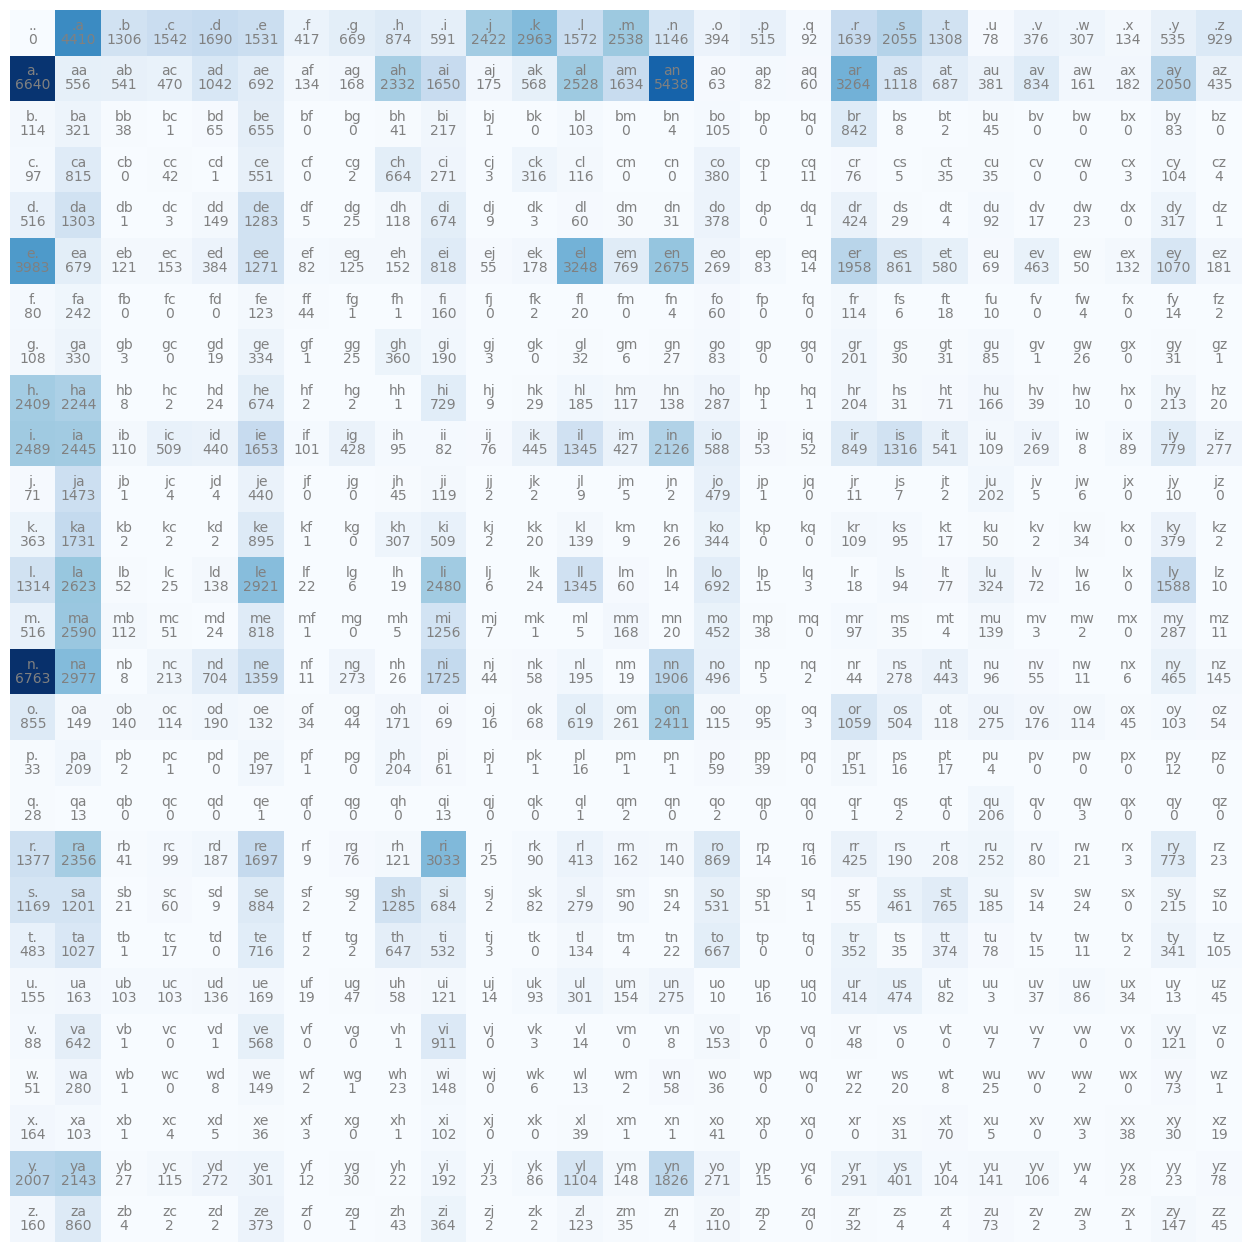

In [5]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [6]:
P = (N+1).float() # N+1 is model smoothing. prevents infs when calculating log(0)
sums = P.sum(dim=1, keepdim=True)
P /= sums

In [7]:
seed = 2147483647
g = torch.Generator().manual_seed(seed)

names = []
for _ in range(10):
    name = []
    idx = 0
    while True:
        idx = torch.multinomial(P[idx], num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        name += itos[idx]

    name = "".join(name)
    names.append(name)

names

['mor',
 'axx',
 'minaymoryles',
 'kondlaisah',
 'anchshizarie',
 'odaren',
 'iaddash',
 'h',
 'jhinatien',
 'egushl']

In [8]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

nll = -log_likelihood/n
print(f'{nll}')
    

2.4543561935424805


In [9]:
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xenc = F.one_hot(xs, num_classes=27).float()

In [16]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [34]:
for k in range(100):
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(probs)), ys].log().mean()
    if (k+1)%10 == 0:
        print(loss.item())
    # backward pass
    W.grad = None
    loss.backward()
    W.data += -50.0 * W.grad

2.4570515155792236
2.4569828510284424
2.4569170475006104
2.4568536281585693
2.4567930698394775
2.456735134124756
2.456679105758667
2.456625461578369
2.456573247909546
2.4565234184265137


In [37]:
g = torch.Generator().manual_seed(2147483647)

names = []
for i in range(10):
    out = []
    idx = 0
    while True:
        xenc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)

        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        out.append(itos[idx])
    names.append(''.join(out))

print(names)

['mor', 'axx', 'minaymoryles', 'kondlaisah', 'anchshizarie', 'odaren', 'iaddash', 'h', 'jhinatien', 'egushk']
